In [25]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
name='3C279'
ra=194.046527
dec=-5.789314

In [3]:
#disp=DispatcherAPI(host='https://www.astro.unige.ch/cdci/astrooda/dispatch-data',instrument='mock',protocol='https')
cookies=dict(_oauth2_proxy=open('token').read().strip())
disp=DispatcherAPI(host='analyse-staging-1.2.reproducible.online/dispatch-data',instrument='mock',cookies=cookies,protocol='https')

In [5]:
f = open('scws_'+name+'_isgri_10deg.txt', 'r')
scws=[]
for line in f:
    line = line.strip()
    columns = line.split()
    scws.append(columns[0])
f.close()
m=int(len(scws)/50.)
print(m)
scw_lists=[]
for i in range(m):
    count=0
    j=0    
    scw_string=''
    while(count<50):
        scw_string=scw_string+str(scws[50*i+count])+','
        count=count+1
    scw_lists.append(scw_string[:-1])

25


In [10]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists[0],
                      E1_keV=20.0,
                      E2_keV=40.0,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=3.5,
                      product_type='Real')

waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data


query done succesfully!


In [11]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,unicode15,float64,float64,float64,int64,int64,int64,object
2,3C 273,18.170305252075195,187.2891845703125,2.057224750518799,-32768,2,0,0.000280000007479
3,3C 279,3.879420757293701,194.04653930664062,-5.789306163787842,-32768,2,0,0.000280000007479
56,NGC 4388,5.55741548538208,186.44554138183594,12.662028312683105,-32768,2,0,0.000280000007479
57,NGC 4593,14.242892265319824,189.9182586669922,-5.369694709777832,-32768,2,0,0.000280000007479
60,NGC 4941,3.6251442432403564,196.05450439453125,-5.5515828132629395,-32768,2,0,0.000280000007479
64,NGC 5506,4.1867218017578125,213.31195068359375,-3.2074999809265137,-32768,2,0,0.000280000007479
65,PKS 1217+02,3.532562255859375,185.08299255371094,2.056999921798706,-32768,1,0,0.0583333335817
74,NEW_1,6.105274677276611,178.76161193847656,5.505251884460449,-32767,0,0,None


In [12]:
torm=[]
for ID,n in enumerate(data.dispatcher_catalog_1.table['src_names']):
    if(n=='NEW_1'):
        torm.append(ID)
data.dispatcher_catalog_1.table.remove_rows(torm)

In [13]:
data.dispatcher_catalog_1.table


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,unicode15,float64,float64,float64,int64,int64,int64,object
2,3C 273,18.170305252075195,187.2891845703125,2.057224750518799,-32768,2,0,0.000280000007479
3,3C 279,3.879420757293701,194.04653930664062,-5.789306163787842,-32768,2,0,0.000280000007479
56,NGC 4388,5.55741548538208,186.44554138183594,12.662028312683105,-32768,2,0,0.000280000007479
57,NGC 4593,14.242892265319824,189.9182586669922,-5.369694709777832,-32768,2,0,0.000280000007479
60,NGC 4941,3.6251442432403564,196.05450439453125,-5.5515828132629395,-32768,2,0,0.000280000007479
64,NGC 5506,4.1867218017578125,213.31195068359375,-3.2074999809265137,-32768,2,0,0.000280000007479
65,PKS 1217+02,3.532562255859375,185.08299255371094,2.056999921798706,-32768,1,0,0.0583333335817
86,IGR J12131+0700,6.995861530303955,183.20753479003906,6.995861530303955,-32768,1,0,0.000277777784504


In [14]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [15]:
spectrum_results=[]
for i in range(len(scw_lists)):
    print i
    data=disp.get_product(instrument='isgri',
                            product='isgri_spectrum',
                            scw_list=scw_lists[i],
                            query_type='Real',
                            osa_version='OSA10.2',
                            RA=ra,
                            DEC=dec,
                            detection_threshold=5.0,
                            radius=15.,
                            product_type='Real',
                            selected_catalog=api_cat)
    spectrum_results.append(data)

0
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data
the job has been submitted on the remote server
 - the job is working remotely, please wait status=done - job_id=-2687708779227124931  31  

query done succesfully!
1
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data
the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-157574565320734165  65  

query done succesfully!
2
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data
the job has been submitted on the remote server
 / the job is working remotely, please wait status=done - job_id=5197826149312294684  84  

query done succesfully!
3
waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data
the job has been submitted on the r

In [16]:
for ID,s in enumerate(data._p_list):
    print (ID,s.meta_data)

(0, {'src_name': '3C 279', 'product': 'isgri_spectrum'})
(1, {'src_name': '3C 279', 'product': 'isgri_arf'})
(2, {'src_name': '3C 279', 'product': 'isgri_rmf'})
(3, {'src_name': 'NGC 4388', 'product': 'isgri_spectrum'})
(4, {'src_name': 'NGC 4388', 'product': 'isgri_arf'})
(5, {'src_name': 'NGC 4388', 'product': 'isgri_rmf'})
(6, {'src_name': '3C 273', 'product': 'isgri_spectrum'})
(7, {'src_name': '3C 273', 'product': 'isgri_arf'})
(8, {'src_name': '3C 273', 'product': 'isgri_rmf'})
(9, {'src_name': 'NGC 4941', 'product': 'isgri_spectrum'})
(10, {'src_name': 'NGC 4941', 'product': 'isgri_arf'})
(11, {'src_name': 'NGC 4941', 'product': 'isgri_rmf'})
(12, {'src_name': 'Background', 'product': 'isgri_spectrum'})
(13, {'src_name': 'Background', 'product': 'isgri_arf'})
(14, {'src_name': 'Background', 'product': 'isgri_rmf'})
(15, {'src_name': 'PKS 1217+02', 'product': 'isgri_spectrum'})
(16, {'src_name': 'PKS 1217+02', 'product': 'isgri_arf'})
(17, {'src_name': 'PKS 1217+02', 'product': '

In [17]:
import numpy as np
from numpy import sqrt

d=spectrum_results[0]
spec=d._p_list[0].data_unit[1].data
arf=d._p_list[1].data_unit[1].data
rmf=d._p_list[2].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
for k in range(len(scw_lists)):
    d=spectrum_results[k]
    spec=d._p_list[0].data_unit[1].data
    arf=d._p_list[1].data_unit[1].data
    rmf=d._p_list[2].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos

    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos


rate=rate/err
err=1/sqrt(err)
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1))



/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in divide


In [26]:
specname=name+'_spectrum.fits'
arfname=name+'_arf.fits.gz'
rmfname=name+'_rmf.fits.gz'
print specname
!cp spectrum.fits $specname
!cp arf.fits.gz $arfname
!cp rmf.fits.gz $rmfname

print name
hdul = fits.open(name+'_spectrum.fits', mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
spec=hdul[1].data
spec['RATE']=rate
spec['SYS_ERR']=syst
spec['STAT_ERR']=err
hdul.flush()
hdul.close()
hdul = fits.open(name+'_rmf.fits.gz', mode='update')
rmf=hdul[2].data
rmf['MATRIX']=matrix
hdul.flush()
hdul.close()
hdul = fits.open(name+'_arf.fits.gz', mode='update')
arf=hdul[1].data
arf['SPECRESP']=specresp
hdul.flush()
hdul.close()
print tot_expos

3C279_spectrum.fits
3C279
2399685.95496


In [30]:
!./spectrum_fit.sh $name


		XSPEC version: 12.9.0n
	Build Date/Time: Tue Nov  8 18:03:34 2016

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 3C279_spectrum.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: 3C279_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  nan       +/- nan      
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 2.4e+06 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response 3C279_rmf.fits.gz
Response successfully loaded.
XSPEC12>arf 3C279_arf.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     1 channels ignored from  source number 1
XSPEC12>ignore **-20.
     8 chan

In [33]:
data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        T1='2015-06-15T15:56:45',
                        T2='2015-06-16T06:13:10',
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        detection_threshold=5.0,
                        radius=15.,
                        product_type='Real',
                        selected_catalog=api_cat)

waiting for remote response, please wait run_analysis https://analyse-staging-1.2.reproducible.online/dispatch-data
the job has been submitted on the remote server
 \ the job is working remotely, please wait status=done - job_id=5049070276391507368  68  

query done succesfully!


In [ ]:
data._p_list[0].write_fits_file(name+'_flare_spectrum.fits')
data._p_list[1].write_fits_file(name+'_flare_arf.fits.gz')
data._p_list[2].write_fits_file(name+'_flare_rmf.fits.gz')

In [ ]:
name1=name+'_flare'
!./spectrum_fit.sh $name1

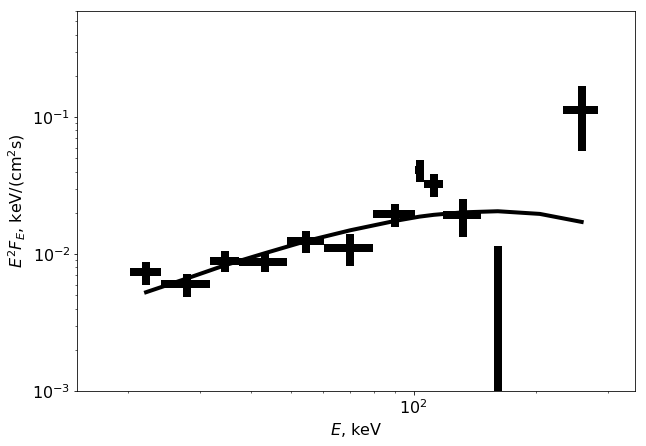

In [32]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=1)
plt.plot(en,mo,color='black',linewidth=4)

spectrum=np.genfromtxt(name+'_flare_spectrum.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5)
plt.plot(en,mo,color='black',linewidth=4,alpha=0.5)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-3,6.e-1)
plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.savefig(name+'_spectra.pdf',format='pdf',dpi=100)


